<a href="https://colab.research.google.com/github/Victor-Kip/Price-Forcasting-and-Purchase-Recommendation-using-AI-in-Ecommerce-Platforms/blob/9-implement-lstm-models/Ecommerce_price_forecasting_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping



In [ ]:
#upload dataset
from google.colab import files
uploaded = files.upload()

Saving data.csv to data (1).csv


In [37]:
#read data from dataset
df = pd.read_csv('data.csv',encoding = 'unicode_escape')
print('original shape:',df.shape)


original shape: (541909, 8)


In [38]:
#remove rows with missing values on key columns
df = df.dropna(subset=['CustomerID', 'Description', 'UnitPrice', 'Quantity'])
#remove cancellations
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

In [39]:
#convert date column
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
#keep positive quantities and prices
df[(df['Quantity']>0) & (df['UnitPrice']>0)]
print("After cleaning: ",df.shape)

After cleaning:  (397924, 8)


In [40]:
#use the top 50 products
top_products = df['StockCode'].value_counts().nlargest(50).index.tolist()
df = df[df['StockCode'].isin(top_products)]

In [41]:
df['Week'] = df['InvoiceDate'].dt.to_period('W').apply(lambda r: r.start_time)
agg = (
    df.groupby(['Week', 'StockCode'])
    .agg(avg_price = ('UnitPrice','mean'),
         qty = ('Quantity','sum'))
    .reset_index()
)

In [42]:
#fill missing weeks per product
out = []
for pid,g in agg.groupby('StockCode'):
  g = g.set_index('Week').asfreq('W-MON')
  g['avg_price'] = g['avg_price'].interpolate('linear').ffill().bfill()
  g['qty'] = g['qty'].fillna(0)
  g['StockCode'] = pid
  out.append(g.reset_index())

df_weekly = pd.concat(out,ignore_index=True)
print("Weekly aggregated shape:",df_weekly.shape)

Weekly aggregated shape: (2474, 4)


In [43]:
def create_windows(series_df, window=12, horizon=1):
    X, y = [], []
    arr = series_df[['avg_price', 'qty']].values
    for i in range(len(arr) - window - horizon + 1):
        X.append(arr[i:i+window])
        y.append(arr[i+window:i+window+horizon, 0])  # predict price
    return np.array(X), np.array(y)


In [44]:
# Collect sliding windows for all products
allX, ally = [], []
for pid, g in df_weekly.groupby('StockCode'):
    g = g.sort_values('Week')
    X, y = create_windows(g, window=12, horizon=1)
    if len(X) > 0:
        allX.append(X)
        ally.append(y)

X = np.vstack(allX)
y = np.vstack(ally).squeeze()
print("Final dataset:", X.shape, y.shape)

Final dataset: (1874, 12, 2) (1874,)


In [52]:
#split between train data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [53]:
x_scaler = MinMaxScaler()
n_samples, n_steps, n_features = X_train.shape
X_train_reshaped = X_train.reshape(-1, n_features)
X_test_reshaped = X_test.reshape(-1, n_features)

X_train_scaled = x_scaler.fit_transform(X_train_reshaped).reshape(n_samples, n_steps, n_features)
X_test_scaled = x_scaler.transform(X_test_reshaped).reshape(X_test.shape[0], n_steps, n_features)

In [54]:
from tensorflow.keras.layers import Input

#build lstm model
model = Sequential([
    LSTM(64,return_sequences=True,input_shape = (X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(1)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [55]:
#compile model
model.compile(optimizer='adam', loss='mse')
es = EarlyStopping(monitor='val_loss',patience=8, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=80,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

Epoch 1/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 9.4954 - val_loss: 1.0115
Epoch 2/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.5142 - val_loss: 0.1330
Epoch 3/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2118 - val_loss: 0.0865
Epoch 4/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0564 - val_loss: 0.0783
Epoch 5/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0380 - val_loss: 0.0706
Epoch 6/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0306 - val_loss: 0.0711
Epoch 7/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0266 - val_loss: 0.0716
Epoch 8/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0236 - val_loss: 0.0678
Epoch 9/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0185 - val_loss: 0.0677
Epoch 10/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0165 - val_loss: 0.0709
Epoch 11/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0135 - val_loss: 0.0669
Epoch 12/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
MSE: 729.11


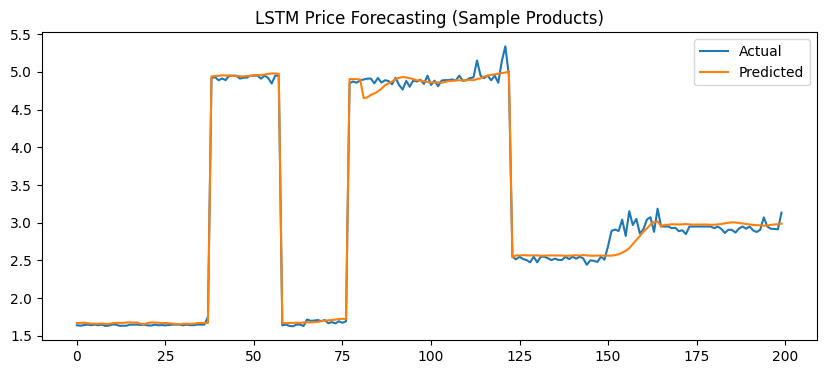

In [56]:
#evaluate model
#prediction
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test,y_pred)
print(f"MSE: {mse:.2f}")

plt.figure(figsize=(10,4))
plt.plot(y_test[:200], label='Actual')
plt.plot(y_pred[:200], label='Predicted')
plt.legend()
plt.title("LSTM Price Forecasting (Sample Products)")
plt.show()

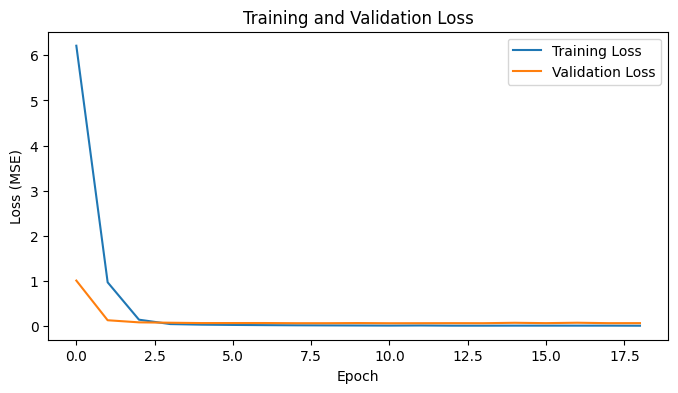

In [57]:

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

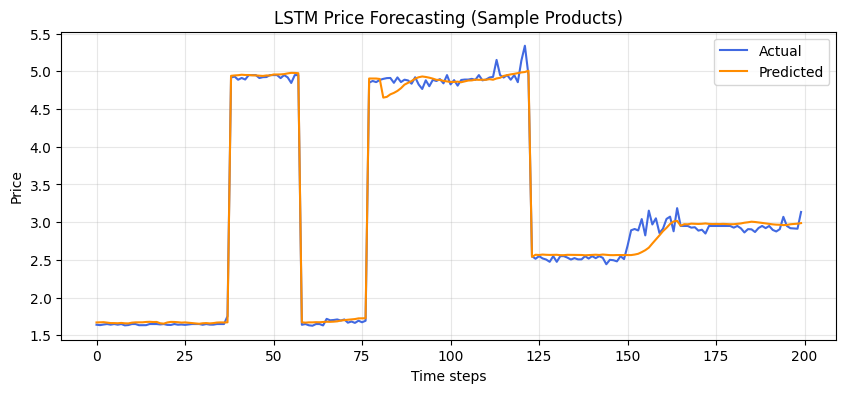

In [59]:
plt.figure(figsize=(10,4))
plt.plot(y_test[:200], label='Actual', linewidth=1.5, color='royalblue')
plt.plot(y_pred[:200], label='Predicted', linewidth=1.5, color='darkorange')
plt.title('LSTM Price Forecasting (Sample Products)', fontsize=12)
plt.xlabel('Time steps')
plt.ylabel('Price')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [60]:
print("Max:",y_test.max())
print("Min:",y_test.min())
print("Mean:",y_test.mean())

Max: 527.109375
Min: 1.6277777777777775
Mean: 6.668111042585693


In [66]:
mape = mean_absolute_percentage_error(y_test,y_pred)*100
print(f"MAPE:{mape:.2f}%")

MAPE:6.66%
